# 1. Setup and Get Data

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

## 1.1 Install Dependencies and Setup

In [ ]:
# !pip install labelme opencv-python matplotlib albumentations

## 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
os.getcwd()

'C:\\Users\\saba\\Desktop\\machine_learning\\face_detection'

In [ ]:
# working_directory = '/mnt/c/Users/saba/Desktop/machine_learning/face_detection/'
# os.chdir(working_directory)
# os.getcwd()

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 25

In [4]:
def testDevice(source):
   cap = cv2.VideoCapture(source) 
   if cap is None or not cap.isOpened():
       print('Warning: unable to open video source: ', source)

testDevice(0) # no printout
testDevice(1) # prints message
testDevice(2)
testDevice(3)

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    # imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    # cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate Images with LabelMe

In [10]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\saba\.labelmerc


# 2. Review Dataset and Build Image Loading Function

## 2.1 Import TF and Dependencies

In [7]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [8]:
# Avoid OOM errors by setting GPU memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.3 Load Image into TF Data Pipeline

In [14]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [15]:
images.as_numpy_iterator().next()

b'data\\images\\1dde60e4-d218-11ec-9c63-d8bbc13d240a.jpg'

In [13]:
def load_image(x):
    # x: full file path
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [17]:
images = images.map(load_image)

In [18]:
images.as_numpy_iterator().next()

array([[[199, 201, 198],
        [198, 200, 197],
        [199, 201, 198],
        ...,
        [ 20,   6,   6],
        [ 20,   6,   6],
        [ 20,   6,   6]],

       [[199, 201, 198],
        [198, 200, 197],
        [199, 201, 198],
        ...,
        [ 20,   6,   6],
        [ 20,   6,   6],
        [ 20,   6,   6]],

       [[199, 201, 198],
        [198, 200, 197],
        [199, 201, 198],
        ...,
        [ 20,   6,   6],
        [ 20,   6,   6],
        [ 20,   6,   6]],

       ...,

       [[125, 135, 108],
        [125, 135, 108],
        [124, 137, 109],
        ...,
        [ 34,   8,  11],
        [ 34,   8,  11],
        [ 34,   8,  11]],

       [[125, 135, 108],
        [125, 135, 108],
        [124, 137, 109],
        ...,
        [ 34,   8,  11],
        [ 34,   8,  11],
        [ 34,   8,  11]],

       [[127, 137, 110],
        [128, 138, 111],
        [127, 140, 112],
        ...,
        [ 34,   8,  11],
        [ 34,   8,  11],
        [ 33,   7,  10]]

In [19]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 View Raw Images with Matplotlib

In [20]:
image_generator = images.batch(4).as_numpy_iterator()

In [32]:
plot_images = image_generator.next()

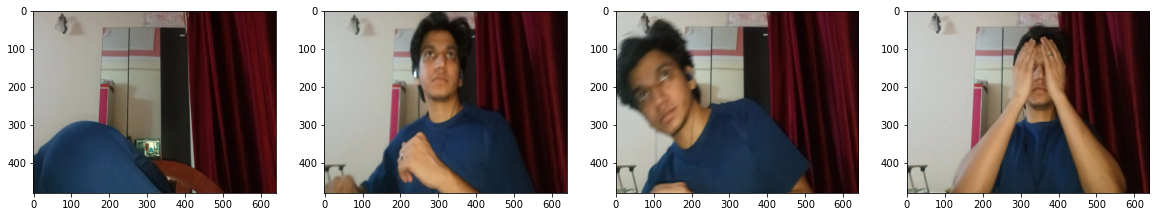

In [33]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 MANUALLY SPLIT DATA INTO TRAIN, TEST AND VAL

In [ ]:
# train = 70
# test = 15
# val = 15

## 3.2 Move the Matching Labels

In [34]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipeline

In [35]:
import albumentations as alb

In [36]:
augmentor = alb.Compose([alb.RandomCrop(width = 450, height = 450),
                         alb.HorizontalFlip(p = 0.5),
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RandomGamma(p = 0.2),
                         alb.RGBShift(p = 0.2),
                         alb.VerticalFlip(p = 0.5)],
                         bbox_params = alb.BboxParams(format = 'albumentations',
                                                      label_fields = ['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [37]:
img = cv2.imread(os.path.join('data', 'train', 'images', '16eaebed-d218-11ec-adec-d8bbc13d240a.jpg'))

In [38]:
img.shape

(480, 640, 3)

In [39]:
with open(os.path.join('data', 'train', 'labels', '16eaebed-d218-11ec-adec-d8bbc13d240a.json'), 'r') as f:
    label = json.load(f)

In [40]:
type(label)

dict

In [47]:
label.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

In [41]:
label['shapes'][0]

{'label': 'face',
 'points': [[275.55102040816325, 87.89795918367349],
  [405.14285714285717, 254.22448979591837]],
 'group_id': None,
 'shape_type': 'rectangle',
 'flags': {}}

In [42]:
label['shapes'][0]['points']

[[275.55102040816325, 87.89795918367349],
 [405.14285714285717, 254.22448979591837]]

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [43]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [44]:
coords

[275.55102040816325, 87.89795918367349, 405.14285714285717, 254.22448979591837]

In [45]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [46]:
coords

[0.4305484693877551,
 0.18312074829931976,
 0.6330357142857144,
 0.5296343537414966]

## 4.4 Apply Augmentations and View Results

In [48]:
augmented = augmentor(image = img, bboxes = [coords], class_labels = ['face'])

In [49]:
type(augmented)

dict

In [50]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [51]:
augmented['bboxes']

[(0.264126984126984,
  0.19310657596371889,
  0.5521088435374151,
  0.5627210884353742)]

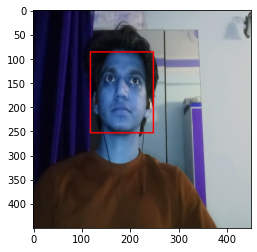

In [52]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [53]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))
        
        num_of_augmentation_per_image = 60
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

## 5.2 Load Augmented Images to Tensorflow Dataset

In [14]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [15]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [16]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images =val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [57]:
train_images.as_numpy_iterator().next()

array([[[0.        , 0.05692402, 0.08829657],
        [0.        , 0.06403186, 0.09540441],
        [0.        , 0.06243873, 0.09381127],
        ...,
        [0.5897059 , 0.64460784, 0.5254902 ],
        [0.6044118 , 0.6571691 , 0.5457721 ],
        [0.62218136, 0.6746324 , 0.5692402 ]],

       [[0.        , 0.05490196, 0.0836397 ],
        [0.        , 0.05931373, 0.09068628],
        [0.        , 0.05876226, 0.09013481],
        ...,
        [0.6353554 , 0.6873162 , 0.61966914],
        [0.6357843 , 0.6877451 , 0.62009805],
        [0.6321691 , 0.68351716, 0.6127451 ]],

       [[0.        , 0.05667892, 0.0841299 ],
        [0.        , 0.0627451 , 0.09411765],
        [0.        , 0.05882353, 0.09803922],
        ...,
        [0.627451  , 0.69503677, 0.6177696 ],
        [0.627451  , 0.69503677, 0.6177696 ],
        [0.63480395, 0.69644606, 0.62199754]],

       ...,

       [[0.22990195, 0.04558824, 0.08480392],
        [0.23872548, 0.05833333, 0.10147059],
        [0.20245098, 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [17]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    
    return [label['class']], label['bbox']

## 6.2 Load Labels to Tensorflow Dataset

In [18]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [62]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3464, 0.4707, 0.6343, 0.8403], dtype=float16))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [63]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4200, 4200, 900, 900, 900, 900)

## 7.2 Create Final Datasets (Images/Labels)

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

In [67]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [68]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.505  , 0.1505 , 0.77   , 0.545  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.375  , 0.1615 , 0.67   , 0.5605 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.311  , 0.4792 , 0.619  , 0.906  ],
        [0.299  , 0.05334, 0.598  , 0.4841 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

## 7.3 View Images and Annotations

In [69]:
data_samples = train.as_numpy_iterator()

In [70]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


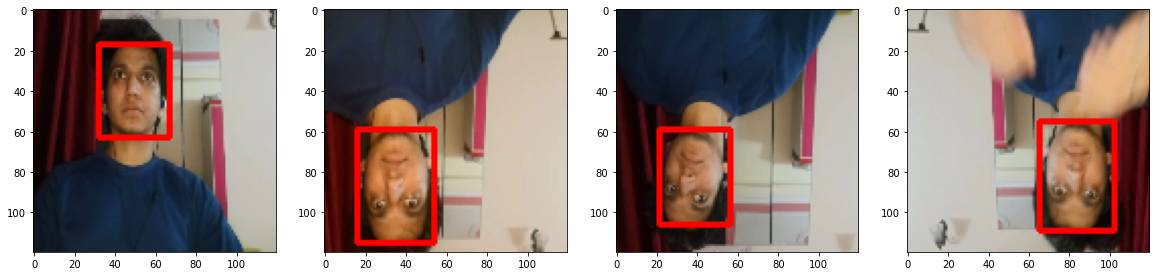

In [71]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

## 8.1 Import Layers and Base Network

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [25]:
vgg = VGG16(include_top=False)

In [26]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of Network

In [27]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test out Neural Network

In [28]:
facetracker = build_model()

In [29]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [78]:
X, y = train.as_numpy_iterator().next()

In [79]:
X.shape

(8, 120, 120, 3)

In [80]:
classes, coords = facetracker.predict(X)

In [81]:
classes, coords

(array([[0.78121895],
        [0.71556115],
        [0.67151856],
        [0.6897931 ],
        [0.68559086],
        [0.78705096],
        [0.7663127 ],
        [0.6722836 ]], dtype=float32),
 array([[0.40195808, 0.46665442, 0.46571606, 0.5393829 ],
        [0.4242661 , 0.6102155 , 0.6070907 , 0.5500472 ],
        [0.3828094 , 0.6373433 , 0.49037117, 0.585776  ],
        [0.39811024, 0.681365  , 0.55581874, 0.68288827],
        [0.45316583, 0.5588479 , 0.67376673, 0.6573329 ],
        [0.4871494 , 0.5735351 , 0.491009  , 0.541669  ],
        [0.44392344, 0.68368244, 0.54081213, 0.6520922 ],
        [0.46942902, 0.62758714, 0.614811  , 0.62339306]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [30]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [32]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [33]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [86]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0727487>

In [87]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.518628>

In [88]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0727487>

# 10. Train Neural Network

## 10.1 Create Custom Model Class

In [90]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            # total_loss = batch_localizationloss+0.5*batch_classloss
            total_loss = batch_localizationloss+0.4*batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [91]:
model = FaceTracker(facetracker)

In [92]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [93]:
logdir='logs'

In [94]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [95]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
525/525 [==============================] - 20s 32ms/step - total_loss: 8.0026e-05 - class_loss: 2.4930e-09 - regress_loss: 8.0025e-05 - val_total_loss: 0.0028 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0028
Epoch 2/10
525/525 [==============================] - 19s 32ms/step - total_loss: 6.0938e-05 - class_loss: 1.9830e-09 - regress_loss: 6.0938e-05 - val_total_loss: 6.4105e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 6.4105e-04
Epoch 3/10
525/525 [==============================] - 19s 32ms/step - total_loss: 6.0501e-05 - class_loss: 1.6573e-09 - regress_loss: 6.0501e-05 - val_total_loss: 0.0066 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0066
Epoch 4/10
525/525 [==============================] - 19s 32ms/step - total_loss: 8.4518e-05 - class_loss: 1.3598e-09 - regress_loss: 8.4518e-05 - val_total_loss: 0.0034 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0034
Epoch 5/10
525/525 [==============================] - 19s 32ms/step - total_loss: 1.2602

## 10.3 Plot Performance

In [96]:
hist.history

{'total_loss': [5.4195585107663646e-05,
  6.626987305935472e-05,
  6.911715172464028e-05,
  7.454233127646148e-05,
  0.00021744160039816052,
  0.00010216828377451748,
  0.00024940440198406577,
  3.143229696433991e-05,
  0.00011944538709940389,
  0.00017396017210558057],
 'class_loss': [1.4901162970204496e-08,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0],
 'regress_loss': [5.418962609837763e-05,
  6.626987305935472e-05,
  6.911715172464028e-05,
  7.454233127646148e-05,
  0.00021744160039816052,
  0.00010216828377451748,
  0.00024940440198406577,
  3.143229696433991e-05,
  0.00011944538709940389,
  0.00017396017210558057],
 'val_total_loss': [0.0028430791571736336,
  0.0006410471396520734,
  0.006565236486494541,
  0.003444189205765724,
  0.0040133036673069,
  0.0019012552220374346,
  0.023991938680410385,
  0.0024918641429394484,
  0.0026751344557851553,
  0.002688254229724407],
 'val_class_loss': [-0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,


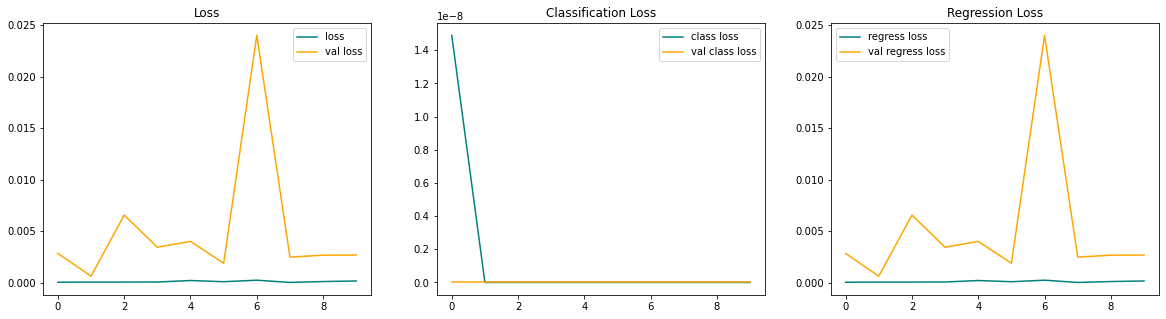

In [97]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

## 11.1 Make Predictions on Test Set

In [98]:
test_data = test.as_numpy_iterator()

In [99]:
test_sample = test_data.next()

In [100]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


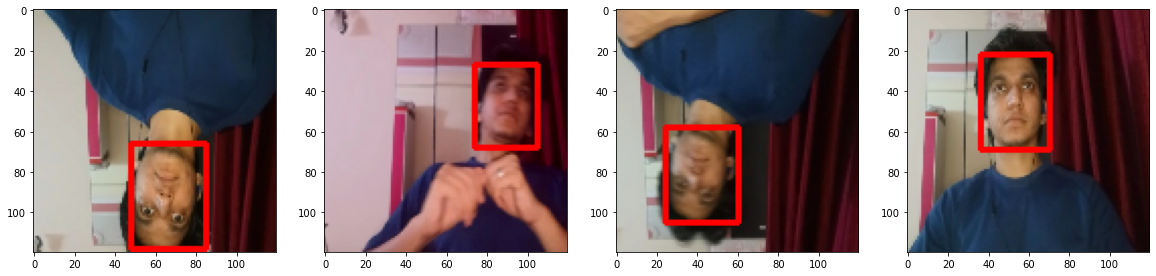

In [101]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [102]:
from tensorflow.keras.models import load_model

In [103]:
facetracker.save('facetracker_may12_10epoch_0_4full_closs.h5')

In [104]:
facetracker = load_model('facetracker_may12_10epoch_0_4full_closs.h5')

## 11.3 Real Time Detection

In [105]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()